# Insight 1 & 2 proposal

### Source:

We find two intersting insights from the draft_combine_stats table, which contains information about player's position, player's body conditions and player's atheletic performance etc 

## Insight 1:

### Target:

We are exploring the relationship between player position and their physical conditions

### Methodology:

- We have chosen heights without shoes, weights, and body fat percentage as features to represent the physical trials of the player 

- We calculate the mean values on these attributes for each position group 
- We use bar chart to show the values in each group for better comparison

### Result: (on average)
1. for height: PG < SG < SF < PF < C
2. for weight: PG < SG < SF < PF < C
3. for body fat percentage: PG < SG < SF < PF < C

### Interpretation:

PG stands for point guards, whose primary role is to carry the ball across the perimeter, hence players in this position are on average shorter and lighter

On the contrary, C (centers) are mainly responsible for blocking and defending, hence players in center position on average would be taller and heavier 


## Insight 2:

### Target:

We are exploring the relationship between player position and their athletic performace

### Methodology:

- We have chosen max_vertical_leap, lane_agility_time, bench_press as features to represent the athletic performance of the player, as these features can be considered as proxy values for explosive power, speed and endurance

- We calculate the mean values on these attributes for each position group 
- We use spider charts to see the performance in each dimension for each position 

### Result: (on average)
1. C and PF: perform the best in bench press
2. PG and SG: perform the best in lane agibility 
3. SG and PG: perform the best in vertical leap

### Interpretation:

Shooting Guards and Point Guards are responsible for shooting and dunking, hence they normally have the best jumping skills and explosive power 

Point Guards and  Shooting Guards require high agility to move pass the perimeter, hence they have the best speed and are the quickest players on the court  


Center and Power Forwards require players are the most physically demanding positions, hence we can see players in these two positsion in general have greater endurance 








In [58]:
import sqlite3 as sql
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

## TODO: Use pathlib to get the path to the data directory. Path(__file__) won't work in a Jupyter notebook.
DATA_PATH = Path.cwd() / 'data' / 'nba.sqlite'

In [13]:
import pandas as pd

# Set the maximum columns displayed to the number of columns in your DataFrame
pd.set_option('display.max_rows', None)


## Load data

In [3]:
con = sql.connect(DATA_PATH)  # connect to the database

query = """
    SELECT *
    FROM draft_combine_stats
""" 

df = pd.read_sql(query, con)


## Feature selection

Proxy features for player's physical condition:
- height_wo_shoes
- weight 
- body_fat_pct

Proxy features for player's athletic performance: 
- max_vertical_leap
- lane_agility_time
- bench_press

In [17]:
df = df[['position', 'height_wo_shoes', 'body_fat_pct', 'weight', 'max_vertical_leap', 'lane_agility_time', 'bench_press']]

## Quick data reporting

1. missing values
2. data types

In [19]:
#report on missing values
print(df.isnull().sum())

#report on data type
print(df.dtypes)

position               0
height_wo_shoes       58
body_fat_pct         357
weight                59
max_vertical_leap    237
lane_agility_time    246
bench_press          538
dtype: int64
position              object
height_wo_shoes      float64
body_fat_pct          object
weight                object
max_vertical_leap    float64
lane_agility_time    float64
bench_press          float64
dtype: object


## Data wrangling for draft_combine_stats (with selected columns)

1. drop rows if target variable 'position' is empty 
2. convert object to float when necessary (for 'weight' column in specific)
3. handle missing values in attribute columns (fill with mean)
4. clean up / standardised labels (for 'position' column in specific)
  


In [50]:
def drop_empty_str_row(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    drop rows in the dataframe if a specified column is an empty string ''.

    Arg:
    df (pd.DataFrame): input dataframe
    col (str): input column name 

    Returns:
    pd.DataFrame: dataframe after the clean-up
    """
    return df[df[col] != '']

In [68]:
df_clean = drop_empty_str_row(df, "position")
print('number of filtered rows:', df.shape[0] - df_clean.shape[0])

number of filtered rows: 5


In [78]:
def convert_float(df: pd.DataFrame, col_list: list) -> pd.DataFrame:
    """
    replace empty strings or None in the specified column with NaN 
    and converts the column to float

    Arg:
    df (pd.DataFrame): input dataframe
    col_list (list): a list of column names to convert to float 

    Returns:
    pd.DataFrame: dataframe after the clean-up
    """
    import numpy as np
    for col in col_list:
        df[col] = df[col].replace(['', None], np.nan)
        df[col] = df[col].astype(float)

    return df


In [79]:
df_clean = convert_float(df_clean, ["weight", "body_fat_pct"])


In [81]:
def fill_na_with_mean(df: pd.DataFrame, col_list: list) -> pd.DataFrame:
    """
    fill NaN values in the specified list of columns with the mean of each column.

    Arg:
    df (pd.DataFrame): input dataframe
    col_list (list): a list of column names to fill NaN values in

    Returns:
    pd.DataFrame: dataframe after the processing 
    """
    for col in col_list:
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)
    return df

In [82]:
df_clean = fill_na_with_mean(df_clean, ['height_wo_shoes', 
'body_fat_pct', 'weight', 'max_vertical_leap', 'lane_agility_time', 'bench_press'])

In [89]:
def cleanup_position(df: pd.DataFrame) -> pd.DataFrame:
    """
    clean up hybrid position labels 
    
    Args:
    df (pd.DataFrame): input dataframe
   
    Returns:
    pd.DataFrame: dataframe after the clean-up
    """
    position_dict = {
        'C-PF': 'C-PF',
        'PF-C': 'C-PF',
        'PF-SF': 'PF-SF',
        'SF-PF': 'PF-SF',
        'SG-PG': 'PG-SG',
        'PG-SG': 'PG-SG',
        'SF-SG': 'SG-SF',
        'SG-SF': 'SG-SF'
    }
    df['position'] = df['position'].replace(position_dict)
    return df

In [90]:
df_clean = cleanup_position(df_clean)

In [91]:
df_clean['position'].unique()

array(['C-PF', 'SG-SF', 'PF', 'C', 'PG', 'SF', 'PG-SG', 'PF-SF', 'SG'],
      dtype=object)

In [86]:
def groupby_mean(df: pd.DataFrame, groupby_col: str) -> pd.DataFrame:
    """
    aggregate the df by a specified column and calculate the mean for other columns

    Args:
    df (pd.DataFrame): input dataframe
    groupby_col (str): column to perform groupby action on 

    Returns:
    pd.DataFrame: dataframe after the groupby action
    """
    agg_df = df.groupby(groupby_col, as_index=False).mean()
    return agg_df

In [92]:
df_agg = groupby_mean(df_clean, "position")
df_agg

,position,height_wo_shoes,body_fat_pct,weight,max_vertical_leap,lane_agility_time,bench_press
0,C,82.031425,8.859519,247.548541,31.960900,11.911933,10.465258
1,C-PF,81.129639,9.150001,243.145213,32.126701,11.863328,12.215785
2,PF,79.699793,8.121852,232.564045,33.847695,11.540037,11.579892
3,PF-SF,79.425621,7.975791,225.379110,33.827216,11.525505,10.401491
4,PG,72.894080,6.647852,186.654194,35.702779,11.121872,8.919116
5,PG-SG,74.434466,6.965947,192.566019,35.458858,11.260206,8.968123
6,SF,78.309505,7.106551,214.231353,35.092911,11.346611,10.141305
7,SG,75.822160,6.802214,201.389171,35.850665,11.162532,10.182379
8,SG-SF,77.035299,6.881411,208.213678,35.456686,11.305203,9.607024


## Visualisation
1. bar chart to see average for each position 
2. radar chart for each position

#### Insight 1: position VS body conditions

In [101]:
def bar_plot_position(df: pd.DataFrame, metrics: list) -> None:
    """
    plot bar chart for each specified metric by position
    
    Args:
    df (pd.DataFrame): dataframe (after aggregation)
    metrics (list): list of metrics (average value)
    
    Returns:
    None
    """
    for metric in metrics:
        #sort by values 
        sorted_df = df.sort_values(by=metric, ascending=False)
        # plot bar chart
        plt.figure(figsize=(6, 2))
        plt.bar(sorted_df["position"], sorted_df[metric])
        plt.xlabel("Position")
        plt.title(f"{metric} by Position")
        plt.xticks(rotation=45)
        plt.show()


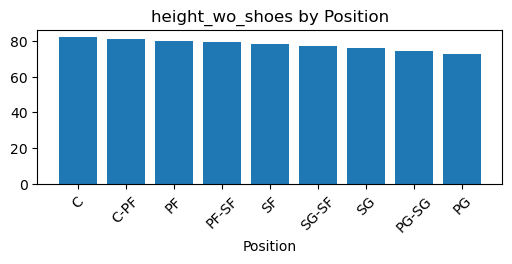

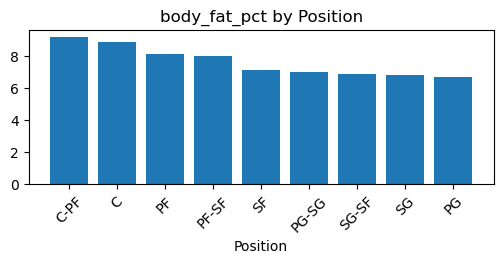

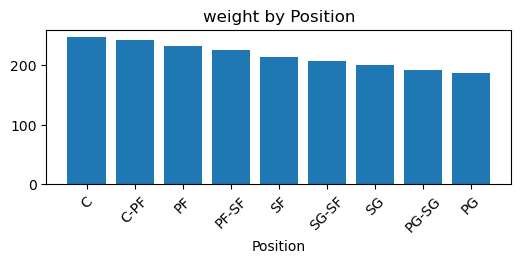

In [110]:

bar_plot_position(df_agg, ['height_wo_shoes', 'body_fat_pct', 'weight'])

#### Insight 2: position VS athletic performance

In [123]:
def rador_plot_position(df: pd.DataFrame) -> None:
    """
    create radar plots for each position
    
    Args:
    df (pd.DataFrame): dataframe containing 'max_vertical_leap', 'lane_agility_time', 'bench_press'
    
    Returns:
    None
    """
    #filter our hybrid position 
    df = df[df['position'].isin(['SG', 'PG', 'SF', 'PF', 'C'])]

    # normalised and transform data
    # max_vertical_leap: high means better explosive_power
    # lane_agility_time: shorter means faster speed -> take the inverse
    # bench_press: larger means greater endurance 
    min_leap = df['max_vertical_leap'].min()
    max_leap = df['max_vertical_leap'].max()
    min_agility = df['lane_agility_time'].min()
    max_agility = df['lane_agility_time'].max()
    min_press = df['bench_press'].min()
    max_press = df['bench_press'].max()
    df_normalized = df.copy()
    df_normalized['explosive_power'] = df['max_vertical_leap'].apply(lambda x: (x - min_leap) / (max_leap- min_leap))
    df_normalized['speed'] = df['lane_agility_time'].apply(lambda x: (1/x - 1/max_agility) / (1/min_agility - 1/max_agility))
    df_normalized['endurance'] = df['bench_press'].apply(lambda x: (x - min_press) / (max_press - min_press))

    # Create radar plots for each position
    for _, row in df_normalized.iterrows():
        # Values for the radar chart, add the first value to close the loop
        values = row[['explosive_power', 'speed', 'endurance']].values.tolist()
        values += values[:1]  # Close the loop

        # Define the angle for each axis
        angles = np.linspace(0, 2 * np.pi, 3, endpoint=False).tolist()
        angles += angles[:1]  # Close the loop

        # Initialize the radar chart
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111, polar=True)

        # Draw the outline and fill in the area
        ax.fill(angles, values, color='skyblue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2)

        # Set labels for each metric
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(['explosive_power', 'speed', 'endurance'], fontsize=10)

        # Set the title with the position name
        position_name = row['position']
        ax.set_title(f"{position_name} Profile", size=15, color='blue', y=1.1)

        # Show each radar plot individually
        plt.show()


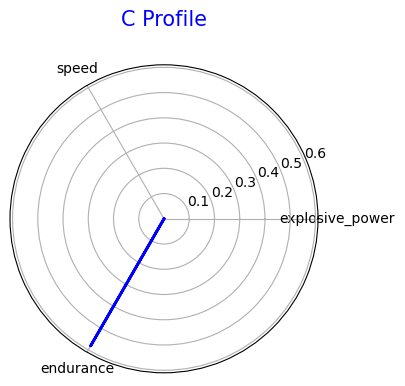

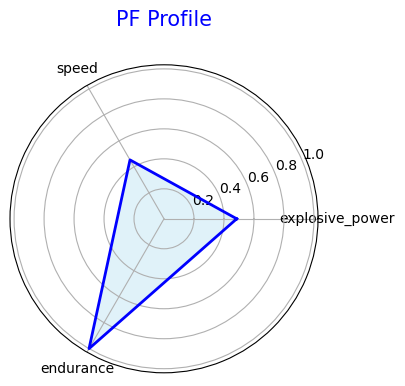

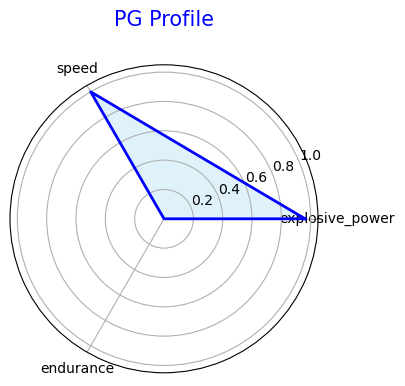

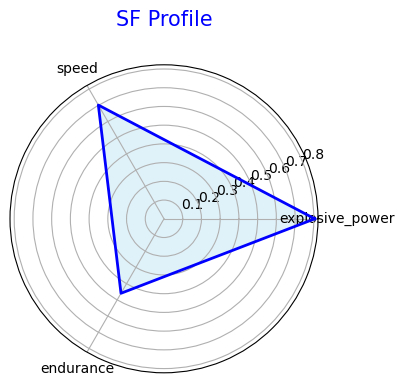

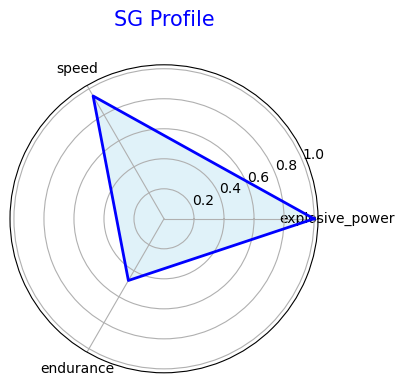

In [124]:
import numpy as np
rador_plot_position(df_agg)